<a href="https://colab.research.google.com/github/Kalazclint/HdayBuzz-ContentClassifier/blob/main/NasNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_file = '/content/drive/My Drive/dataset/train.csv'


In [ ]:


import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
df = pd.read_csv(csv_file)
df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
image_folder_path = '/content/drive/My Drive/dataset/train/'
image_size = (331, 331)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder_path,
    x_col="Image",
    y_col="Class",
    target_size=image_size,
    batch_size=128,
    subset='training',
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_folder_path,
    x_col="Image",
    y_col="Class",
    target_size=image_size,
    batch_size=128,
    subset='validation',
    class_mode='categorical'
)


Found 4140 validated image filenames belonging to 6 classes.
Found 258 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


KeyboardInterrupt: ignored

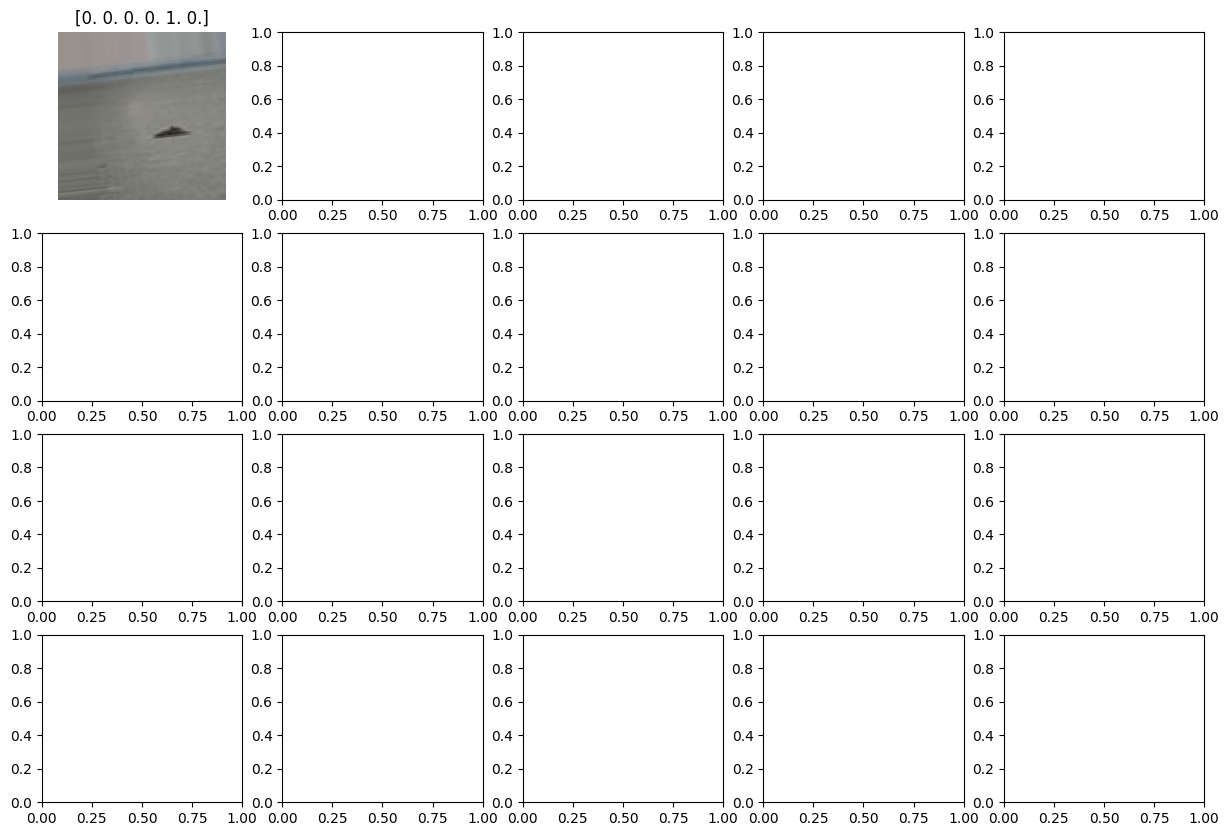

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    image, label = train_generator.next()
    ax.imshow(image[0])
    ax.set_title(label[0])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, optimizers

# Load NASNetLarge model + higher-level layers
base_model = NASNetLarge(weights='imagenet',  # Load weights pre-trained on ImageNet
                         include_top=False,   # Do not include the ImageNet classifier at the top
                         input_shape=(331, 331, 3))  # Required input shape for NASNetLarge

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom model on top of the NASNetLarge base
model = models.Sequential()
model.add(base_model)  # Add the NASNetLarge base model

# Add custom layers on top for classification
model.add(layers.GlobalAveragePooling2D())  # Add global average pooling layer to reduce spatial dimensions
model.add(layers.Dense(256, activation='relu'))  # Fully connected layer with 256 hidden units and ReLU activation
#model.add(layers.Dropout(0.3))  # Dropout for regularization
model.add(layers.Dense(6, activation='softmax'))  # Final classification layer - adjust the number of units for your number of classes

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),  # Adjust learning rate as needed
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])  # Monitor accuracy during training


343610240/343610240 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Adjust number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/20
32/32 [==============================] - 4040s 125s/step - loss: 1.1075 - accuracy: 0.6482 - val_loss: 0.5870 - val_accuracy: 0.7617
Epoch 2/20
32/32 [==============================] - 3947s 123s/step - loss: 0.6339 - accuracy: 0.7727 - val_loss: 0.5190 - val_accuracy: 0.8438
Epoch 3/20
32/32 [==============================] - 3941s 123s/step - loss: 0.5418 - accuracy: 0.8033 - val_loss: 0.5094 - val_accuracy: 0.8203
Epoch 4/20
32/32 [==============================] - 3926s 123s/step - loss: 0.4451 - accuracy: 0.8330 - val_loss: 0.6261 - val_accuracy: 0.7969
Epoch 5/20
32/32 [==============================] - 3898s 122s/step - loss: 0.4481 - accuracy: 0.8385 - val_loss: 0.4550 - val_accuracy: 0.8359
Epoch 6/20
32/32 [==============================] - 3948s 123s/step - loss: 0.4008 - accuracy: 0.8539 - val_loss: 0.4247 - val_accuracy: 0.8359
Epoch 7/20
32/32 [==============================] - 3935s 123s/step - loss: 0.4043 - accuracy: 0.8527 - val_loss: 0.4715 - val_accuracy:

In [ ]:
# Assuming you have a test_generator prepared
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


3/3 [==============================] - 240s 60s/step - loss: 0.4499 - accuracy: 0.8682
Test Accuracy: 86.82%
Test Loss: 0.4499


In [12]:
# Reset the validation_generator before making predictions
validation_generator.reset()

# Make predictions using the model
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1, verbose=1)

3/3 [==============================] - 254s 57s/step


In [13]:

# Map predictions to labels
predicted_indices = np.argmax(predictions, axis=1)
# Get a reverse mapping from index to class
label_map = {v: k for k, v in validation_generator.class_indices.items()}
predicted_labels = [label_map[i] for i in predicted_indices]

In [14]:
# Get true labels
true_labels = validation_generator.classes  # These are the true class indices

# Convert true class indices to labels
true_labels = [label_map[i] for i in true_labels]

# Get image filenames
filenames = validation_generator.filenames

In [15]:
# Create a DataFrame and save to CSV
results_df = pd.DataFrame(list(zip(filenames, true_labels, predicted_labels)), columns=['Image', 'True_Class', 'Predicted_Class'])


In [19]:
results_df.head(50)



,Image,True_Class,Predicted_Class
208,image5602.jpg,Jacket,Miscellaneous
209,image2724.jpg,Christmas_Tree,Miscellaneous
210,image8790.jpg,Candle,Airplane
211,image2710.jpg,Christmas_Tree,Candle
212,image9551.jpg,Miscellaneous,Christmas_Tree
213,image5741.jpg,Miscellaneous,Christmas_Tree
214,image3010.jpg,Jacket,Miscellaneous
215,image5806.jpg,Christmas_Tree,Miscellaneous
216,image2575.jpg,Jacket,Miscellaneous
217,image1632.jpg,Christmas_Tree,Miscellaneous
